In [1]:
import pydiffvg
import torch
import os

In [2]:
image_path = "../data/test/output_image.jpg"

In [3]:
def render(canvas_width, canvas_height, shapes, shape_groups):
    _render = pydiffvg.RenderFunction.apply
    scene_args=pydiffvg.RenderFunction.serialize_scene(\
        canvas_height=canvas_height,\
        canvas_width=canvas_width,\
        shapes=shapes,\
        shape_groups=shape_groups)
    img = _render(
        canvas_width,
        canvas_height,
        2,
        2,
        0,
        None,
        *scene_args
    )
    return img

In [4]:
pydiffvg.set_device(torch.device("cuda"))

In [5]:
svg = os.path.join("../data/test/output.svg")

In [6]:
canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(svg)

In [7]:
ref = render(canvas_width, canvas_height, shapes, shape_groups)

In [8]:
ref.shape

torch.Size([384, 384, 4])

In [9]:
pydiffvg.imwrite(ref.cpu(), "test_render.png", gamma=2.2)

In [10]:
shape_groups[0].fill_color

tensor([0.8314, 0.6824, 0.3843, 1.0000])

# Aesthetic Evaluator Torch


In [11]:
import contextlib
from pathlib import Path

import clip
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch import nn

class AestheticPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.layers(x)
    
class AestheticEvaluatorTorch:
    def __init__(self):
        self.model_path = "../models/sac+logos+ava1-l14-linearMSE.pth"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.predictor, self.clip_model, self.preprocessor = self.load()

    def load(self):
        state_dict = torch.load(self.model_path, weights_only=True, map_location=self.device)

        predictor = AestheticPredictor(768).half()
        predictor.load_state_dict(state_dict)
        predictor.to(self.device)
        predictor.eval()

        clip_model, _ = clip.load(
                "ViT-L/14", device=self.device)
        preprocessor = transforms.Compose(
            [
                transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
                transforms.CenterCrop(224),
                # transforms.Lambda(lambda x: x.clamp_(0, 1)),
                transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
            ]
        )
        return predictor, clip_model, preprocessor
    
    def score(self, image: torch.Tensor, no_grad: bool = True):
        if image.ndim != 4:
            raise ValueError(f"image must be 4 channels (shape: {image.shape})")
        
        with torch.no_grad() if no_grad else contextlib.nullcontext():
            image = self.preprocessor(image)
            image_features = self.clip_model.encode_image(image)

            image_features /= image_features.norm(dim=-1, keepdim=True)

            score_tensor = self.predictor(image_features)
        
        return score_tensor / 10



In [12]:
aesthetic_evaluator = AestheticEvaluatorTorch()

In [13]:
ref.shape[-1]

4

In [14]:
if ref.shape[-1] == 4:
    ref = ref[..., :3]  # Bỏ kênh alpha

# Chuyển từ HWC -> CHW
ref = ref.permute(2, 0, 1)  # [3, H, W]

# Thêm batch dimension
ref = ref.unsqueeze(0)  # [1, 3, H, W]

# Đưa lên GPU nếu model đang ở cuda:1
ref = ref.to("cuda")

In [15]:
score = aesthetic_evaluator.score(ref)

In [16]:
score.shape

torch.Size([1, 1])

In [17]:
import pydiffvg
import argparse
import ttools.modules
import torch
import skimage.io

gamma = 1.0


In [18]:
import torch.nn.functional as F
import skimage.io

target = torch.from_numpy(skimage.io.imread("../data/test/output_image.jpg")).to(torch.float32) / 255.0
target = target.pow(gamma)
target = target.to(pydiffvg.get_device())
target = target.unsqueeze(0)  # [1, H, W, C]
target = target.permute(0, 3, 1, 2)  # [1, C, H, W]

# ✅ Resize về [1, 3, 384, 384]
target = F.interpolate(target, size=(384, 384), mode='bilinear', align_corners=False)


In [19]:
target.shape

torch.Size([1, 3, 384, 384])

In [20]:
canvas_width, canvas_height, shapes, shape_groups = \
    pydiffvg.svg_to_scene(svg)
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)

render = pydiffvg.RenderFunction.apply
img = render(canvas_width, # width
                canvas_height, # height
                2,   # num_samples_x
                2,   # num_samples_y
                0,   # seed
                None, # bg
                *scene_args)

In [21]:
img.shape

torch.Size([384, 384, 4])

In [22]:
points_vars = []
for path in shapes:
    path.points.requires_grad = True
    points_vars.append(path.points)
color_vars = {}
for group in shape_groups:
    group.fill_color.requires_grad = True
    color_vars[group.fill_color.data_ptr()] = group.fill_color
color_vars = list(color_vars.values())

In [23]:
points_optim = torch.optim.Adam(points_vars, lr=1.0)
color_optim = torch.optim.Adam(color_vars, lr=0.01)

In [24]:
loss_list = []

In [25]:
from tqdm import tqdm
num_iter = 300

In [26]:
for _ in tqdm(range(num_iter)):
    points_optim.zero_grad()
    color_optim.zero_grad()

    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups
    )

    img = render(canvas_width, canvas_height, 2, 2, 0, None, *scene_args)
    if img.shape[-1] == 4:
        image = img[..., :3]  # Bỏ kênh alpha
    image = image.permute(2, 0, 1)  # HWC -> CHW
    image = image.unsqueeze(0)

    
    aesthetic = aesthetic_evaluator.score(image)
    
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    img = img[:, :, :3]
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW


    # loss = - aesthetic + (img - target).pow(2).mean()
    loss = (img-target).pow(2).mean()
    loss_list.append(loss.item())
    
    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    points_optim.step()
    color_optim.step()
    for group in shape_groups:
        group.fill_color.data.clamp_(0.0, 1.0)

pydiffvg.save_svg('results.svg',
                            canvas_width, canvas_height, shapes, shape_groups)


100%|██████████| 300/300 [00:16<00:00, 17.80it/s]


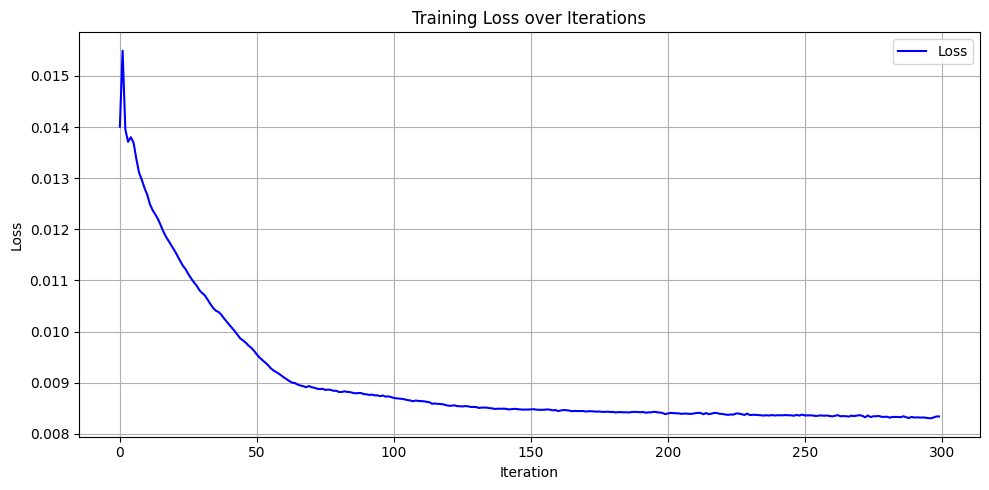

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Loss', color='blue')
plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
